In [1]:
#@title 1. Install Dependencies & Imports
!pip install torch torchvision opencv-python tqdm perlin-noise

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import math
import random
import cv2
import numpy as np
import os
import sys
from tqdm.notebook import tqdm
from perlin_noise import PerlinNoise

# Check Device
if torch.cuda.is_available():
    DEVICE = "cuda"
    print("Using CUDA GPU")
else:
    DEVICE = "cpu"
    print("Using CPU")

Using CUDA GPU


In [2]:
#@title 2. Core Logic (VHSTorch)
# File: vhs_torch.py

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import math
import random

class VHSTorch:
    """
    Applies a series of effects to an image to simulate the look of an analog VHS tape.
    PyTorch implementation for GPU acceleration.
    """
    def __init__(self, lumaCompressionRate: float, lumaNoiseSigma: float, lumaNoiseMean: float,
                 chromaCompressionRate: float, chromaNoiseIntensity: float,
                 verticalBlur: int, horizontalBlur: int, borderSize: float, generations: int,
                 device: str = "mps"):
        self.lumaCompressionRate = lumaCompressionRate
        self.lumaNoiseSigma = lumaNoiseSigma
        self.lumaNoiseMean = lumaNoiseMean
        self.chromaCompressionRate = chromaCompressionRate
        self.chromaNoiseIntensity = chromaNoiseIntensity
        self.verticalBlur = int(verticalBlur)
        self.horizontalBlur = int(horizontalBlur)
        self.borderSize = borderSize / 100
        self.generation = int(generations)
        self.device = device

    def addNoise(self, image: torch.Tensor, mean: float = 0, sigma: float = 30) -> torch.Tensor:
        # image is (C, H, W) float tensor
        noise = torch.randn_like(image, device=self.device) * sigma + mean
        return torch.clamp(image + noise, 0, 255)

    def addChromaNoise(self, image: torch.Tensor, intensity: int = 10) -> torch.Tensor:
        # image is (H, W) or (C, H, W). We expect (3, H, W) in standard flow but function signature in original vhs.py implies it might modify channels.
        # Original: noise_b, noise_g, noise_r added to channels 0,1,2 respectively.
        # Here input is Y, Cr, Cb (3 channels).
        # We generate integer noise.
        c, h, w = image.shape
        noise = torch.randint(-intensity, intensity + 1, (c, h, w), device=self.device, dtype=torch.float32)
        return torch.clamp(image + noise, 0, 255)

    def cut_black_line_border(self, image: torch.Tensor, bordersize: int = None) -> torch.Tensor:
        # image: (C, H, W)
        _, h, w = image.shape
        line_width = int(w * self.borderSize) if bordersize is None else bordersize
        if line_width > 0:
            image[..., -line_width:] = 0
        return image

    def compressLuma(self, image: torch.Tensor) -> torch.Tensor:
        # image: (C, H, W), typically expecting Y channel mainly? Original takes full YCrCb.
        # Actually original compresses the whole image passed to it.
        c, h, w = image.shape
        new_width = max(1, int(w / self.lumaCompressionRate))

        # Step 1: Downscale
        # interpolate expects (N, C, H, W) usually, but (C,H,W) works with some modes or if unsqueezed.
        # mode='bilinear' or 'bicubic' are closest to Lanczos for GPU efficiency. Lanczos not native in torch interpolate.
        img_unsqueezed = image.unsqueeze(0)
        step1 = F.interpolate(img_unsqueezed, size=(h, new_width), mode='bicubic', align_corners=False)

        # Add noise
        step1 = self.addNoise(step1.squeeze(0), self.lumaNoiseMean, self.lumaNoiseSigma).unsqueeze(0)

        # Step 2: Upscale
        step2 = F.interpolate(step1, size=(h, w), mode='bicubic', align_corners=False).squeeze(0)

        step2 = self.cut_black_line_border(step2)
        return step2

    def compressChroma(self, image: torch.Tensor) -> torch.Tensor:
        # image: (C, H, W)
        c, h, w = image.shape
        new_width = max(1, int(w / self.chromaCompressionRate))

        img_unsqueezed = image.unsqueeze(0)
        step1 = F.interpolate(img_unsqueezed, size=(h, new_width), mode='bicubic', align_corners=False)
        step1 = self.addChromaNoise(step1.squeeze(0), int(self.chromaNoiseIntensity)).unsqueeze(0)

        step2 = F.interpolate(step1, size=(h, w), mode='bicubic', align_corners=False).squeeze(0)
        step2 = self.cut_black_line_border(step2)
        return step2

    def blur(self, image: torch.Tensor) -> torch.Tensor:
        h_blur = max(1, int(self.horizontalBlur) if int(self.horizontalBlur) % 2 != 0 else int(self.horizontalBlur) + 1)
        v_blur = max(1, int(self.verticalBlur) if int(self.verticalBlur) % 2 != 0 else int(self.verticalBlur) + 1)

        # GaussianBlur expects (..., H, W)
        return TF.gaussian_blur(image, kernel_size=[v_blur, h_blur])

    def waves(self, img: torch.Tensor) -> torch.Tensor:
        # img: (C, H, W)
        c, rows, cols = img.shape

        # Create grid
        # i: vertical index (0 to rows-1), j: horizontal index (0 to cols-1)
        # We need per-pixel displacement.

        wave_intensity = round(random.uniform(0.000, 1.110), 3)

        # Construct meshgrid on GPU
        grid_y, grid_x = torch.meshgrid(torch.arange(rows, device=self.device), torch.arange(cols, device=self.device), indexing='ij')

        # offset_x calculation
        # offset_x = (waves * np.sin(250 * 2 * np.pi * i / (2 * cols))).astype(int)
        # Note: 'i' in original is rows index.

        # 2 * cols = period?
        # 250 * 2 * pi * i / (2 * cols)

        arg = (250.0 * 2 * math.pi * grid_y) / (2 * cols)
        offset_x = (wave_intensity * torch.sin(arg)).long()

        # Apply offset to grid_x
        target_x = torch.clamp(grid_x + offset_x, 0, cols - 1)

        # Gather pixels
        # img[:, grid_y, target_x]
        # We can use Advanced Indexing

        return img[:, grid_y, target_x]

    def waves2(self, img: torch.Tensor) -> torch.Tensor:
        c, rows, cols = img.shape
        grid_y, grid_x = torch.meshgrid(torch.arange(rows, device=self.device), torch.arange(cols, device=self.device), indexing='ij')

        # waves = round(random.uniform(1.000, 1.110), 3)
        # offset_x = (waves * np.sin(np.cos(random.randint(200, 250)) * 2 * np.pi * i / (2 * cols))).astype(int)

        wave_intensity = round(random.uniform(1.000, 1.110), 3)
        random_factor = random.randint(200, 250)

        arg = (math.cos(random_factor) * 2 * math.pi * grid_y) / (2 * cols)
        offset_x = (wave_intensity * torch.sin(arg)).long()

        target_x = torch.clamp(grid_x + offset_x, 0, cols - 1)
        return img[:, grid_y, target_x]

    def switchNoise(self, img: torch.Tensor) -> torch.Tensor:
        c, rows, cols = img.shape
        grid_y, grid_x = torch.meshgrid(torch.arange(rows, device=self.device), torch.arange(cols, device=self.device), indexing='ij')

        # waves = round(random.uniform(1.900, 1.910), 3)
        # offset_x = (waves * np.sin(np.cos(250) * 2 * np.pi * i / (2 * cols))).astype(int)
        # offset_j = np.clip(j + (offset_x * random.randint(20, 30)), 0, cols - 1)

        wave_intensity = round(random.uniform(1.900, 1.910), 3)
        arg = (math.cos(250) * 2 * math.pi * grid_y) / (2 * cols)
        offset_x = (wave_intensity * torch.sin(arg)).long()

        rand_mult = random.randint(20, 30)
        target_x = torch.clamp(grid_x + (offset_x * rand_mult), 0, cols - 1)

        return img[:, grid_y, target_x]

    def sharpen2(self, image: torch.Tensor, kernel_size=(5, 5), sigma=100.0, alpha=1.5, beta=-0.5) -> torch.Tensor:
        # blurred = cv2.GaussianBlur(image, kernel_size, sigma)
        # unsharp_mask = cv2.addWeighted(image, alpha, blurred, beta, 0)

        blurred = TF.gaussian_blur(image, kernel_size=list(kernel_size), sigma=sigma)
        unsharp_mask = image * alpha + blurred * beta
        return torch.clamp(unsharp_mask, 0, 255)

    def sharpen_image(self, image: torch.Tensor) -> torch.Tensor:
        # Expected input: BGR (3, H, W)
        # Original logic converts to BGRA, does HPF, blends.
        # We will stay in 3 channels if possible or append alpha strictly if needed.
        # The blend logic in original:
        # hpf = image_bgra - cv2.GaussianBlur(image_bgra, (21, 21), 3) + 127
        # blended = ...

        # Let's work on (3, H, W) directly for efficiency, assuming alpha not critical for math unless 'waves' introduces transparency? No.

        blurred_large = TF.gaussian_blur(image, kernel_size=[21, 21], sigma=3.0)
        hpf = image - blurred_large + 127.0

        image_norm = image / 255.0
        hpf_norm = hpf / 255.0

        # blended_norm = np.where(hpf_norm <= 0.5, 2 * image_norm * hpf_norm, 1 - 2 * (1 - image_norm) * (1 - hpf_norm))
        # PyTorch `where`

        cond = hpf_norm <= 0.5
        case1 = 2 * image_norm * hpf_norm
        case2 = 1 - 2 * (1 - image_norm) * (1 - hpf_norm)

        blended_norm = torch.where(cond, case1, case2)
        blended_norm = torch.clamp(blended_norm, 0, 1)

        return blended_norm * 255.0

    def processFrame(self, image: torch.Tensor) -> torch.Tensor:
        # Input (3, H, W) BGR (or RGB, logic is color space agnostic mostly until YCrCb)
        # We need RGB <-> YCrCb conversion. OpenCV one.
        # Start: BGR

        # Convert BGR -> YCrCb
        # PyTorch doesn't have native Color conversion as robust as CV2 in core, but kornia has. We don't want kornia dep.
        # We can implement simple linear conversion.
        # Y = 0.299R + 0.587G + 0.114B
        # Cr = (R - Y) * 0.713 + 128
        # Cb = (B - Y) * 0.564 + 128
        # Note: Input is BGR.

        # Extract channels
        b = image[0, :, :]
        g = image[1, :, :]
        r = image[2, :, :]

        y = 0.299 * r + 0.587 * g + 0.114 * b
        cr = (r - y) * 0.713 + 128
        cb = (b - y) * 0.564 + 128

        # Stack YCrCb
        ycrcb = torch.stack([y, cr, cb], dim=0)

        # Luma Compression
        luma_compressed = self.compressLuma(ycrcb) # Operate on all channels or just 0? Original: copy() passed to compressLuma, logic adds noise to all?
        # Original:
        # luma_compressed = self.compressLuma(image_ycrcb.copy())
        # -> compressLuma -> resize -> addNoise (all channels) -> resize
        # So yes, it operates on full image

        # Chroma Compression
        chroma_compressed = self.compressChroma(ycrcb)

        # Waves on chroma
        chroma_compressed = self.waves(chroma_compressed)
        chroma_compressed = self.waves2(chroma_compressed)

        # Merge
        # chrominance_layer = chroma_compressed[:, :, 1:3] (last 2 channels)
        # merged = Luma[0] + Chroma[1,2]

        final_y = luma_compressed[0, :, :]
        final_cr = chroma_compressed[1, :, :]
        final_cb = chroma_compressed[2, :, :]

        # Convert back to BGR
        # R = Y + 1.403 (Cr - 128)
        # G = Y - 0.714 (Cr - 128) - 0.344 (Cb - 128)
        # B = Y + 1.773 (Cb - 128)

        r_out = final_y + 1.403 * (final_cr - 128)
        g_out = final_y - 0.714 * (final_cr - 128) - 0.344 * (final_cb - 128)
        b_out = final_y + 1.773 * (final_cb - 128)

        out = torch.stack([b_out, g_out, r_out], dim=0)
        return torch.clamp(out, 0, 255)

    def applyVHSEffect(self, image: torch.Tensor) -> torch.Tensor:
        # image: (3, H, W) Tensor on Device, float32 0-255 range preferred or uint8

        originalValues = [self.lumaNoiseSigma, self.lumaNoiseMean, self.chromaNoiseIntensity]

        self.lumaNoiseSigma *= self.generation
        self.lumaNoiseMean *= self.generation
        self.chromaNoiseIntensity *= self.generation

        processed_image = self.processAll(image)

        self.lumaNoiseSigma = originalValues[0]
        self.lumaNoiseMean = originalValues[1]
        self.chromaNoiseIntensity = originalValues[2]

        return processed_image

    def processAll(self, image: torch.Tensor) -> torch.Tensor:
        image = self.sharpen_image(image)
        image = self.switchNoise(image)
        image = self.processFrame(image)
        image = self.waves(image)
        image = self.waves2(image)
        image = self.blur(image)
        image = self.sharpen2(image)
        return image

In [4]:
#@title 3. Mount Google Drive
from google.colab import drive
drive.mount('/drive')
print('Google Drive mounted at /drive/MyDrive')

Mounted at /drive
Google Drive mounted at /drive/MyDrive


In [20]:
#@title 4. Configuration

#@markdown ### Input/Output
#@markdown Paths relative to your Drive, e.g., `/drive/MyDrive/input.mp4`
input_video_path = '/drive/MyDrive/videos/countdown.mov' #@param {type:"string"}
output_video_path = '/drive/MyDrive/videos/output_vhs.mp4' #@param {type:"string"}

#@markdown ### VHS Effects Settings
luma_compression = 1.88 #@param {type:"slider", min:1, max:3, step:0.01}
luma_noise_sigma = 5 #@param {type:"slider", min:1, max:10, step:1}
luma_noise_mean = -4 #@param {type:"slider", min:-100, max:100, step:1}
chroma_compression = 8 #@param {type:"slider", min:1, max:100, step:1}
chroma_noise_intensity = 6 #@param {type:"slider", min:1, max:100, step:1}
vertical_blur = 5 #@param {type:"slider", min:1, max:15, step:1}
horizontal_blur = 4 #@param {type:"slider", min:1, max:15, step:1}
border_size = 1.51 #@param {type:"slider", min:1, max:3, step:0.01}
generations = 4 #@param {type:"slider", min:2, max:10, step:1}

print("Configuration Loaded.")

Configuration Loaded.


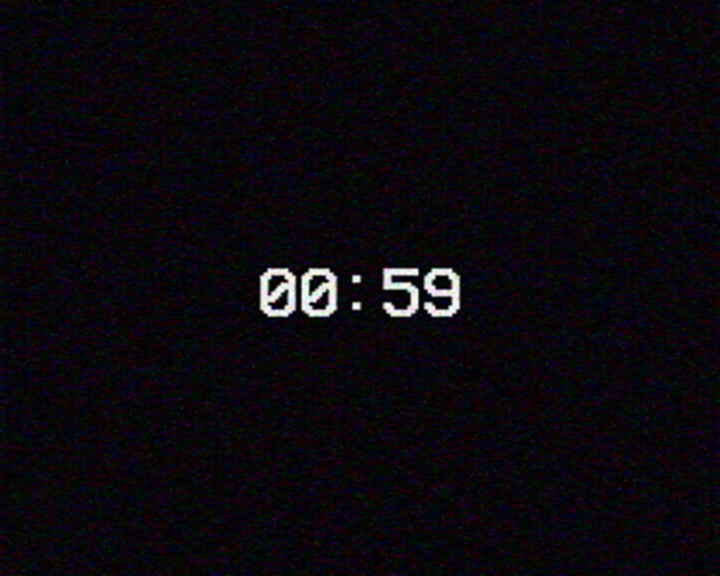

In [21]:

#@title 5. Preview Single Frame
preview_frame_index = 10 #@param {type:"integer"}

if not os.path.exists(input_video_path):
    print(f"Error: {input_video_path} not found!")

else:
    # Init Processor with static settings
    processor = VHSTorch(
        lumaCompressionRate=luma_compression,
        lumaNoiseSigma=luma_noise_sigma,
        lumaNoiseMean=luma_noise_mean,
        chromaCompressionRate=chroma_compression,
        chromaNoiseIntensity=chroma_noise_intensity,
        verticalBlur=int(vertical_blur),
        horizontalBlur=int(horizontal_blur),
        borderSize=border_size / 100, # Important scaling
        generations=int(generations),
        device=DEVICE
    )

    cap = cv2.VideoCapture(input_video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    target = min(preview_frame_index, total_frames - 1)

    cap.set(cv2.CAP_PROP_POS_FRAMES, target)
    ret, frame = cap.read()
    cap.release()

    if ret:
        t_frame = torch.from_numpy(frame).permute(2,0,1).float().to(DEVICE)
        res = processor.applyVHSEffect(t_frame)
        res_np = res.permute(1,2,0).detach().cpu().numpy().astype(np.uint8)

        out_img = f"preview_frame_{target}.jpg"
        cv2.imwrite(out_img, res_np)

        from IPython.display import Image, display
        display(Image(filename=out_img))
    else:
        print("Error reading frame.")

In [22]:

#@title 6. Run Video Processing
print(f"Starting processing: {input_video_path} -> {output_video_path}")

if not os.path.exists(input_video_path):
    print(f"Error: {input_video_path} not found!")

else:
    # Re-init processor (clean state)
    processor = VHSTorch(
        lumaCompressionRate=luma_compression,
        lumaNoiseSigma=luma_noise_sigma,
        lumaNoiseMean=luma_noise_mean,
        chromaCompressionRate=chroma_compression,
        chromaNoiseIntensity=chroma_noise_intensity,
        verticalBlur=int(vertical_blur),
        horizontalBlur=int(horizontal_blur),
        borderSize=border_size / 100, # Important scaling
        generations=int(generations),
        device=DEVICE
    )

    cap = cv2.VideoCapture(input_video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    try:
        with tqdm(total=total_frames, unit='frame') as pbar:
            frame_idx = 0
            while True:
                ret, frame = cap.read()
                if not ret: break

                t_frame = torch.from_numpy(frame).permute(2,0,1).float().to(DEVICE)
                res = processor.applyVHSEffect(t_frame)
                res_np = res.permute(1,2,0).detach().cpu().numpy().astype(np.uint8)

                out.write(res_np)
                pbar.update(1)
                frame_idx += 1
    finally:
        cap.release()
        out.release()
        print(f"Done. Saved to {output_video_path}")

Starting processing: /drive/MyDrive/videos/countdown.mov -> /drive/MyDrive/videos/output_vhs.mp4


  0%|          | 0/2250 [00:00<?, ?frame/s]

Done. Saved to /drive/MyDrive/videos/output_vhs.mp4
